# Short-term Temperature Model Test

## Import dependencies and data

In [1]:
# import dependencies
import os
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [3]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3, 4]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.loc[:, ('time', 'date')] = pd.to_datetime(data.time.date)

In [4]:
# define X vars
x_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('setpoints', 'TA01_GT10X_GM10X'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter columns to keep only x_vars
data = data[x_vars].copy()

## Describe Df

In [5]:
# print number of NAs
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

Number of NAs

category      sensor_ID       
flow          TA01_GP101          0
              FF01_GP101          0
temperatures  DC_GT401_GM401      0
              TA01_GT10X_GM10X    0
              DC_GT301_damped     0
              DC_GT301_outdoor    0
setpoints     TA01_GT10X_GM10X    0
sun           gsi                 1
              vol                 1
time          mod                 1
              doy                 1
dtype: int64





In [6]:
# remove single NAN
data = data[data.sun.gsi.notnull()]

In [7]:
# describe cols
data.describe().transpose()

count         mean         std  \
category     sensor_ID                                             
flow         TA01_GP101        241679.0  2318.563593  624.297194   
             FF01_GP101        241679.0  2210.922719  586.756278   
temperatures DC_GT401_GM401    241679.0    49.361311    3.537226   
             TA01_GT10X_GM10X  241679.0    20.677345    1.316719   
             DC_GT301_damped   241679.0    -4.863893    6.680358   
             DC_GT301_outdoor  241679.0    -4.888043    6.641713   
setpoints    TA01_GT10X_GM10X  241679.0    20.606454    0.736977   
sun          gsi               241679.0    29.375823   71.267312   
             vol               241679.0   342.029979  961.585469   
time         mod               241679.0     0.637125    0.307487   
             doy               241679.0     0.312164    0.195327   

                                        min          25%          50%  \
category     sensor_ID                                                  
flow         TA01_GP101        0.000000e+00  1857.600000  2023.500000   
             FF01_GP101        0.000000e+00  1787.600000  1925.200000   
temperatures DC_GT401_GM401    0.000000e+00    48.800000    50.100000   
             TA01_GT10X_GM10X  0.000000e+00    19.900000    20.200000   
             DC_GT301_damped  -2.160000e+01   -10.000000    -3.500000   
             DC_GT301_outdoor -2.090000e+01   -10.000000    -3.500000   
setpoints    TA01_GT10X_GM10X  0.000000e+00    20.000000    20.000000   
sun          gsi               0.000000e+00     0.000000     0.004286   
             vol               0.000000e+00     0.000000     0.000000   
time         mod               0.000000e+00     0.384698     0.707107   
             doy               1.224647e-16     0.137279     0.296713   

                                       75%          max  
category     sensor_ID                                   
flow         TA01_GP101        2680.000000  4206.600000  
             FF01_GP101        2546.900000  4043.600000  
temperatures DC_GT401_GM401      51.200000    55.900000  
             TA01_GT10X_GM10X    21.500000    30.600000  
             DC_GT301_damped      0.300000     9.300000  
             DC_GT301_outdoor     0.300000     8.400000  
setpoints    TA01_GT10X_GM10X    21.500000    22.000000  
sun          gsi                 11.602826   491.320000  
             vol                  0.264547  3600.000000  
time         mod                  0.923880     1.000000  
             doy                  0.486273     0.668064

## Process / transform variables 

In [8]:
# remove erroneous setpoints data
data = data[data.setpoints.TA01_GT10X_GM10X != 0.0]

# # set temp to adjusted for setpoint
# data[('temperatures', 'TA01_GT10X_GM10X')] = data.temperatures.TA01_GT10X_GM10X \
#                                                 - (data.setpoints.TA01_GT10X_GM10X - 20.0)

# ## Use temperature Diff. w.r.t. setpoint
# #data[('temperatures', 'TA01_GT10X_GM10X_diff')] = \
# #    data[('temperatures', 'TA01_GT10X_GM10X')] - data[('setpoints', 'TA01_GT10X_GM10X_default')]

# Transform setpoints variable to instead account for difference w.r.t 20 deg C
data[('temperatures', 'setpoint_diff')] = data.setpoints.TA01_GT10X_GM10X - 20.0

In [9]:
# remove "OUTLIERS" from DC-TEMP
# data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_GT401_GM401_roll')] = data.temperatures.DC_GT401_GM401.rolling(window=240, center=False).mean()
data[('temperatures', 'DC_diff')] = np.abs(data.temperatures.DC_GT401_GM401 - data.temperatures.DC_GT401_GM401_roll)
data.loc[data.temperatures.DC_diff > 2, ('temperatures', 'DC_GT401_GM401')] = data.temperatures.DC_GT401_GM401_roll

In [10]:
# remove "OUTLIERS" from DC-FLOW
data[('flow', 'TA01_GP101')] = data.flow.TA01_GP101.apply(lambda val: max(1800, val))

In [11]:
# perform FFT 
fourier = np.fft.rfft( data.temperatures.DC_GT401_GM401.values)

# get FREQS
spacing = 1 / 100 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered = np.fft.irfft(fourier)

# put in data
data.loc[:, ('temperatures', 'DC_GT401_GM401_fft')] = data[('temperatures', 'DC_GT401_GM401')]
data[('temperatures', 'DC_GT401_GM401_fft')].iloc[1:] = filtered

### Plot pairwise correlation matrix

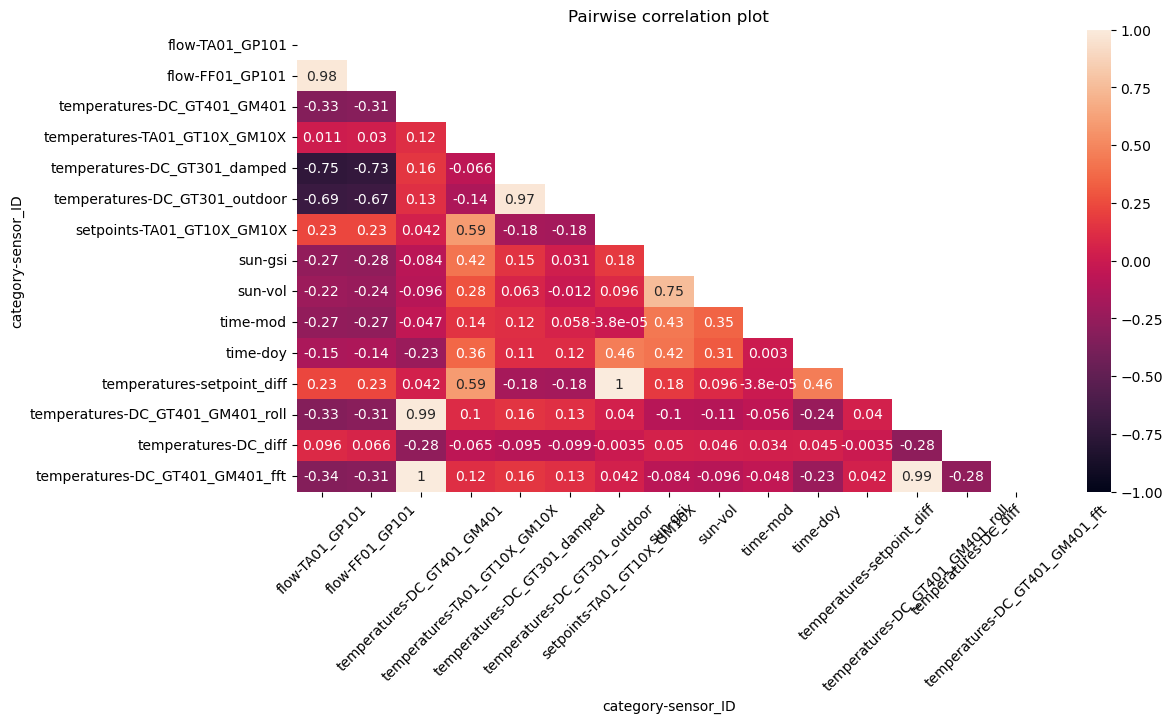

In [12]:
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 6))
sns.heatmap(corr, mask=mask, vmin=-1.0, vmax=1.0, annot=True)

plt.xticks(rotation=45)
plt.title('Pairwise correlation plot')
plt.show()

# delete correlation data
del corr

## Preparing data

In [13]:
t_steps = 20  # 10 minute predictions
n_steps = 60  # 30 minute backwards look

train_frac = 0.8

### Data selection and whitening

In [14]:
# # save temp mean & std

# temp_mean = data.temperatures.TA01_GT10X_GM10X.mean()
# temp_std = data.temperatures.TA01_GT10X_GM10X.std()

In [15]:
# # normalize all columns
# for col in data.columns:
#     data[col] = (data[col] - data[col].mean()) / data[col].std()

In [16]:
# Define model variables
model_vars = [
    ('flow', 'TA01_GP101'),
    ('flow', 'FF01_GP101'),
    ('temperatures', 'DC_GT401_GM401_fft'),
    ('temperatures', 'TA01_GT10X_GM10X'),
    ('temperatures', 'DC_GT301_damped'),
    ('temperatures', 'DC_GT301_outdoor'),
    ('temperatures', 'setpoint_diff'),
    ('sun', 'gsi'),
    ('sun', 'vol'),
    ('time', 'mod'),
    ('time', 'doy')
]

# filter data
data = data[model_vars]

In [18]:
# define target
# targets = data.pop(('temperatures', 'TA01_GT10X_GM10X')).shift(periods=-t_steps)  # 0-minute forward
targets = data[('temperatures', 'TA01_GT10X_GM10X')].copy().shift(periods=-t_steps)

# remove NaNs
targets = targets.iloc[:-t_steps]
data = data.iloc[:-t_steps]

### Create sequences

In [19]:
def date_flagger(data, n_steps):
    # get flagged dates
    data['day'] = data.index.get_level_values(1).values
    data['date_flag'] = data.day - data.day.shift(periods=n_steps) > 1

    # get positions in data, w.r.t. n_step removed observations at start
    flagged_idx = np.where(data.date_flag.values == 1)
    flagged_idx = flagged_idx[0] - n_steps
    
    del data['day'], data['date_flag']
    
    return flagged_idx

In [20]:
# get all n_step-sequences from data series
sequences = np.stack([
    data.values[i:i+n_steps, :] for i in range(len(data) - n_steps)
]) 

# get flagged sequences
flags = date_flagger(data, n_steps)

# get mask f. flags
mask = [idx not in flags for idx in range(len(sequences))]
sequences = sequences[mask]

# get targets, delete mask
targets = targets.values[n_steps:][mask]

In [21]:
# delete data 
del data

# save sequential seqs, targets for testing
sequences, test_seqs  = sequences[:-8640], sequences[-8640:]
targets, test_targets = targets[:-8640], targets[-8640:]

### Shuffle and split dataset

In [22]:
# get random indices
idxs = np.arange(len(targets))
np.random.shuffle(idxs)

# shuffle sequences and targets
sequences = np.squeeze(sequences[idxs])
targets = np.squeeze(targets[idxs])


In [23]:
# split data
train_n = int(len(targets) * train_frac)
#test_n = len(targets) - train_n

X_train, X_test = sequences[:train_n], sequences[train_n:]
Y_train, Y_test = targets[:train_n], targets[train_n:]

In [24]:
# delete vars
del sequences, targets

## Define model

In [33]:
layerList = [
    layers.Input(shape=(
        X_train.shape[1],
        X_train.shape[2]
    )),
    layers.BatchNormalization(),
    layers.Conv1D(
#         filters=64,
        filters=128,
        kernel_size=7, 
        padding="same", 
        strides=2, 
        activation="relu"
    ),
#     layers.SpatialDropout1D(rate=0.2),
    layers.BatchNormalization(),
    layers.Conv1D(
#         filters=32,
        filters=128,
        kernel_size=7, 
        padding="same", 
        strides=2, 
        activation="relu"
    ),
#     layers.SpatialDropout1D(rate=0.2),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        activation='tanh',
        return_sequences=True,
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.BatchNormalization(),
    layers.LSTM(
        units=32,
        activation='tanh',
        recurrent_activation='sigmoid',
        activity_regularizer='l2',
        recurrent_dropout=0.2
    ),
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(
        units=64,
        activation=None,
        activity_regularizer='l2'
    ),
    layers.BatchNormalization(),
    layers.Dense(
        units=1,
        activation=None,
        activity_regularizer='l2'
    )
]

In [34]:
model = tf.keras.models.Sequential(layers=layerList, name='model')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_10 (Bat  (None, 60, 11)           44        
 chNormalization)                                                
                                                                 
 conv1d (Conv1D)             (None, 30, 128)           9984      
                                                                 
 batch_normalization_11 (Bat  (None, 30, 128)          512       
 chNormalization)                                                
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 128)           114816    
                                                                 
 batch_normalization_12 (Bat  (None, 15, 128)          512       
 chNormalization)                                                
                                                             

In [35]:
trainHist = model.fit(
    X_train,
    Y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/20
1163/1163 [==============================] - 67s 53ms/step - loss: 76.1131 - val_loss: 4.6619
Epoch 2/20
1163/1163 [==============================] - 62s 54ms/step - loss: 4.4968 - val_loss: 4.4482
Epoch 3/20
1163/1163 [==============================] - 68s 59ms/step - loss: 4.4447 - val_loss: 5.0647
Epoch 4/20
1163/1163 [==============================] - 63s 54ms/step - loss: 4.4120 - val_loss: 4.8668
Epoch 5/20
1163/1163 [==============================] - 65s 56ms/step - loss: 4.4114 - val_loss: 6.1896
Epoch 6/20
1163/1163 [==============================] - 67s 57ms/step - loss: 4.4010 - val_loss: 4.4598
Epoch 7/20
1163/1163 [==============================] - 64s 55ms/step - loss: 4.3759 - val_loss: 4.3442
Epoch 8/20
1163/1163 [==============================] - 68s 59ms/step - loss: 4.3637 - val_loss: 4.5130
Epoch 9/20
1163/1163 [==============================] - 69s 59ms/step - loss: 4.3571 - val_loss: 4.9496
Epoch 10/20
1163/1163 [==============================] - 68s 58

KeyboardInterrupt: 

In [36]:
preds = model.predict(X_test)
vis_preds = model.predict(test_seqs)

270/270 [==============================] - 3s 11ms/step


In [38]:
test_mae = np.abs(np.squeeze(preds) - Y_test) 
temp_diffs = test_mae# * temp_std

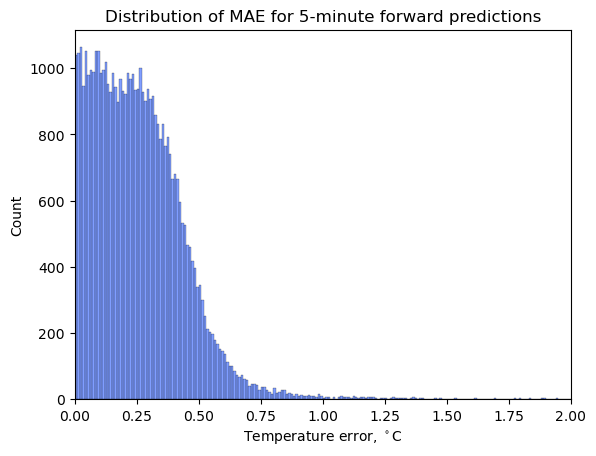

In [39]:
diff_df = pd.DataFrame(temp_diffs)

sns.histplot(
    data=diff_df,
    stat='count',
    binwidth=0.01,
    binrange=[0, 2.0],
    kde=False,
    palette='bright',
    legend=False
)

plt.title('Distribution of MAE for 5-minute forward predictions')
plt.xlim(0, 2.0)
plt.xlabel('Temperature error, $^\circ$C')

plt.savefig('temp_error_dist.png')
plt.show()

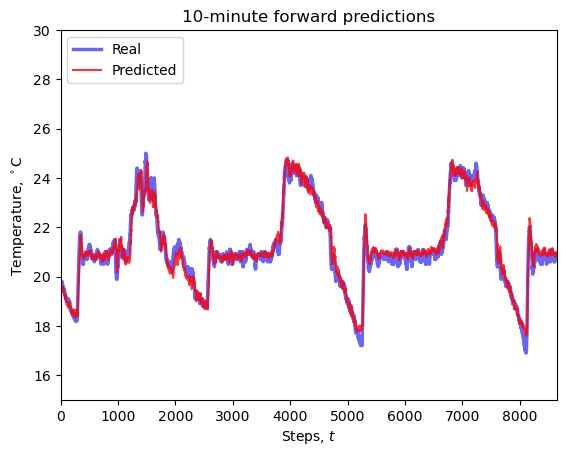

In [42]:
plt.plot(
    np.squeeze(test_targets),# * temp_std + temp_mean,
    c='b',
    alpha=0.6,
    linewidth=2.5,
    label='Real'
)

plt.plot(
    vis_preds,# * temp_std + temp_mean,
    c='r',
    alpha=0.8,
    linewidth=1.5,
    label='Predicted'
)

plt.ylabel('Temperature, $^\circ$C')
plt.xlabel('Steps, $t$')
plt.legend(loc='upper left')
plt.title('10-minute forward predictions')

plt.ylim(15, 30)
plt.xlim(0, len(vis_preds))

plt.show()

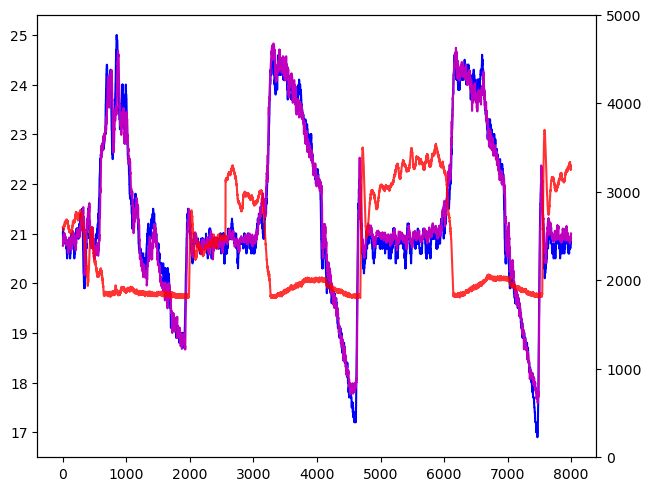

In [79]:
fig, ax = plt.subplots(layout='constrained')
ax.plot(np.squeeze(test_targets)[-8000:], c='b')
ax.plot(vis_preds[-8000:], c='m')

ax_sec = ax.twinx()

ax_sec.plot(test_seqs[-8000:, 0, 0], c='r', linewidth=1.5, alpha=0.8)
ax_sec.set_ylim(0, 5000)
#plt.plot(test_seqs[-4000:, 0, 0])

plt.show()

In [43]:
np.corrcoef(test_targets, np.squeeze(vis_preds))

array([[1.        , 0.98380498],
       [0.98380498, 1.        ]])

In [44]:
np.corrcoef(np.squeeze(preds), Y_test)

array([[1.        , 0.97646967],
       [0.97646967, 1.        ]])